## Scaled Video GAN Prototype

The video GAN implementation is trained on a larger subset of the dataset. Since the neural network architecture is composed of many convolutional layers and a batch size of 1 is equivalent to 32 images, training takes considerable amount of time ~ 2-3 hours for this example. Therefore, I only train the GAN on the subset of size 500 MB.

### What Changed?

The goal of this neural network model is to predict future frames given a single image as an input. My previous small-scaled model essentially learned to generate fake  images of EACH FRAME independently and thus did not learn how to predict future frames. To fix this, here are the following changes made to the implementation:

###### 1. Added an encoder network  
The encoder was appended at the beginning of the networks and is used as the 'initial state' of the expected genereate video. It is essentially conditioning the network on a static image. The encoder reduces the image to a single latent vector of a dimension of 100. However, I plan on experimenting with other pre-trained encoders and/or reducing the image to the size of the first convolutional layer of the generator as input.

###### 2. Modified loss function
A regularized term is added to the loss of the generator. This additional term is computed by taking the mean of the difference between a randomly selected frame (0-32) of the generated video and real video. The reason for this is to penalize the generator if it generates 32 similar frames of the input image being encoded. I am still experimenting with different norm metrics and methods of choosing the random frame to optimize the generators training.

###### 3. Dataset 
After thorough experimentation, the UAV dataset proved to be poor for this application. There were several videos containing up to 10 seconds of similar frames and minimal amount of variance between objects in the video, making it very challenging to showcase the generator's output as a non-static video.

Therefore, I decided to use youtube videos of basketball highlights since it is my favorite sport and players are constantly moving at relatively high running speeds. I created a file that allows you to download videos from youtube, filter them based on duration and number of desired videos, and then save them in a directory as .jpg files. 

###### 4. Created utils.py
I added a utils.py file to make the training function in main.py cleaner and more compact. Other helper functions were included in the utils.py as well.

# Training

The main.py file contains the training function with arguements: filename (pickle file containing image paths), epochs, and regularizer term.

Note that the training was done offline, but the same code was used.

In [42]:
# %load main.py
from keras_preprocessing.image import save_img
from torch import optim
from torch.utils.data import DataLoader
from core.utils import *
from torchvision.transforms import ToPILImage
import logging
from core.model import *
from core.dataset import *
from examples.Logger import Logger
import numpy.random
import sys
import imageio
from skimage import img_as_ubyte


def train_gan(filename=None, epochs=100, l1_lambda=10):
    d_loss, g_loss, d_real_output, d_fake_output = 0, 0, 0, 0
    # Create logger
    logger = Logger(model_name='VGAN', data_name='scaled_training')

    # Get dataloader
    vid_batch = 3
    data_loader = create_dataloader(filename=filename, video_batches=vid_batch)

    # Instantiate generator and discriminator
    generator = VideoGen().float()
    discriminator = VideoDiscriminator().float()

    # Directory to save generator videos
    DIR_TO_SAVE = "./gen_videos/"
    if not os.path.exists(DIR_TO_SAVE):
        os.makedirs(DIR_TO_SAVE)

    # Define optimizer for the discriminator and generator
    d_optimizer = optim.RMSprop(discriminator.parameters(), lr=5e-5)
    g_optimizer = optim.RMSprop(generator.parameters(), lr=5e-5)

    # first frames list
    first_frames = []

    for epoch in range(epochs):
        for (iter_num, batch) in enumerate(data_loader, 1):
            rand_int = numpy.random.randint(0, 32)
            if int(batch['video'].size(0) // 32) == vid_batch:
                real_video = batch['video'].view(vid_batch, 32, 3, 64, 64)
                filenames = batch['filename']
                real_randframe = real_video[:, rand_int:rand_int + 1, :, :, :]
                real_first_frame = real_video[:, 0:1, :, :, :]

                if epoch == 0:
                    first_frames.append(real_first_frame)

                # Generate a fake video first random frame
                fake_video = generator(real_first_frame.squeeze())

                # reset gradients
                generator.zero_grad()
                discriminator.zero_grad()

                # Train discriminator
                if not iter_num % 2 == 0:
                    # detach fake video (generators parameters)
                    fake_video.detach()
                    d_loss, d_real_output, d_fake_output = d_loss_step(generator=generator,
                                                                       discriminator=discriminator,
                                                                       real_video=real_video,
                                                                       fake_video=fake_video)

                    # Update Gradient
                    d_loss.backward()
                    d_optimizer.step()

                    # Clamp
                    for p in discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

                else:  # Train generator
                    g_loss, d_fake_output = g_loss_step(discriminator=discriminator,
                                                        fake_video=fake_video,
                                                        real_randframe=real_randframe,
                                                        rand_int=rand_int,
                                                        l1_lambda=l1_lambda)

                    g_loss.backward()
                    g_optimizer.step()

                if iter_num % 2 == 0:
                    logger.display_status(
                        epoch, epochs, iter_num, len(data_loader),
                        d_loss, g_loss, d_real_output, d_fake_output
                    )

        real_frame_id = epoch % (len(data_loader) - 2)
        gen_out = generator(first_frames[real_frame_id].squeeze())

        t = gen_out.data.cpu()[0:1, :, 0:1, :, :].squeeze()

        save_img(x=np.transpose(t, (1, 2, 0)),
                 path=DIR_TO_SAVE + 'fake_img_sample_it%s_epoch%s.jpg' % (iter_num, epoch))

        # Save video from generator
        make_gif(denorm(gen_out.data.cpu()[0]),
                 DIR_TO_SAVE + 'fake_gifs_sample_it%s_epoch%s.gif' % (iter_num, epoch))

    return generator, discriminator


if __name__ == '__main__':
    gen, dis = train_gan('vid1.pickle.pickle', epochs=150)


Using TensorFlow backend.


Epoch: [0/40], Batch Num: [2/25]
Discriminator Loss: 0.2607, Generator Loss: 4.8114
D(x): 0.0294, D(G(z)): -0.0979
Epoch: [0/40], Batch Num: [4/25]
Discriminator Loss: -0.0608, Generator Loss: 4.1725
D(x): 0.0384, D(G(z)): -0.1070
Epoch: [0/40], Batch Num: [6/25]
Discriminator Loss: -0.1251, Generator Loss: 4.4122
D(x): 0.1007, D(G(z)): -0.1341
Epoch: [0/40], Batch Num: [8/25]
Discriminator Loss: -0.1886, Generator Loss: 3.7396
D(x): 0.1196, D(G(z)): -0.1654
Epoch: [0/40], Batch Num: [10/25]
Discriminator Loss: -0.2680, Generator Loss: 5.5119
D(x): 0.1359, D(G(z)): -0.1989
Epoch: [0/40], Batch Num: [12/25]
Discriminator Loss: -0.2375, Generator Loss: 3.8321
D(x): 0.0805, D(G(z)): -0.2195
Epoch: [0/40], Batch Num: [14/25]
Discriminator Loss: -0.3644, Generator Loss: 3.3230
D(x): 0.1708, D(G(z)): -0.2410
Epoch: [0/40], Batch Num: [16/25]
Discriminator Loss: -0.4181, Generator Loss: 3.4566
D(x): 0.2170, D(G(z)): -0.2584
Epoch: [0/40], Batch Num: [18/25]
Discriminator Loss: -0.3645, Genera

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch: [1/40], Batch Num: [2/25]
Discriminator Loss: -0.5295, Generator Loss: 4.1165
D(x): 0.2427, D(G(z)): -0.3248
Epoch: [1/40], Batch Num: [4/25]
Discriminator Loss: -0.5888, Generator Loss: 4.0141
D(x): 0.2731, D(G(z)): -0.3466
Epoch: [1/40], Batch Num: [6/25]
Discriminator Loss: -0.6355, Generator Loss: 3.1784
D(x): 0.3150, D(G(z)): -0.3574
Epoch: [1/40], Batch Num: [8/25]
Discriminator Loss: -0.6774, Generator Loss: 3.2940
D(x): 0.3260, D(G(z)): -0.3836
Epoch: [1/40], Batch Num: [10/25]
Discriminator Loss: -0.6778, Generator Loss: 5.3507
D(x): 0.3193, D(G(z)): -0.3792
Epoch: [1/40], Batch Num: [12/25]
Discriminator Loss: -0.6135, Generator Loss: 3.4691
D(x): 0.2394, D(G(z)): -0.4136
Epoch: [1/40], Batch Num: [14/25]
Discriminator Loss: -0.7582, Generator Loss: 3.2052
D(x): 0.3591, D(G(z)): -0.4321
Epoch: [1/40], Batch Num: [16/25]
Discriminator Loss: -0.7976, Generator Loss: 3.3994
D(x): 0.3858, D(G(z)): -0.4403
Epoch: [1/40], Batch Num: [18/25]
Discriminator Loss: -0.7452, Gener

Epoch: [6/40], Batch Num: [24/25]
Discriminator Loss: -1.3497, Generator Loss: 3.0048
D(x): 0.8285, D(G(z)): -0.7397
Epoch: [7/40], Batch Num: [2/25]
Discriminator Loss: -1.3636, Generator Loss: 3.7874
D(x): 0.7898, D(G(z)): -0.5787
Epoch: [7/40], Batch Num: [4/25]
Discriminator Loss: -1.6219, Generator Loss: 2.8617
D(x): 0.7756, D(G(z)): -0.8121
Epoch: [7/40], Batch Num: [6/25]
Discriminator Loss: -1.5556, Generator Loss: 2.9110
D(x): 0.8893, D(G(z)): -0.8910
Epoch: [7/40], Batch Num: [8/25]
Discriminator Loss: -1.6856, Generator Loss: 3.0555
D(x): 0.8069, D(G(z)): -0.8644
Epoch: [7/40], Batch Num: [10/25]
Discriminator Loss: -1.6348, Generator Loss: 4.6413
D(x): 0.8488, D(G(z)): -0.7022
Epoch: [7/40], Batch Num: [12/25]
Discriminator Loss: -1.6195, Generator Loss: 2.9679
D(x): 0.7755, D(G(z)): -0.5145
Epoch: [7/40], Batch Num: [14/25]
Discriminator Loss: -1.4520, Generator Loss: 2.7508
D(x): 0.8842, D(G(z)): -0.8560
Epoch: [7/40], Batch Num: [16/25]
Discriminator Loss: -1.4859, Gener

Epoch: [12/40], Batch Num: [22/25]
Discriminator Loss: -0.5199, Generator Loss: 1.9724
D(x): 0.6903, D(G(z)): 0.0130
Epoch: [12/40], Batch Num: [24/25]
Discriminator Loss: -0.5278, Generator Loss: 1.9669
D(x): 0.6895, D(G(z)): 0.0911
Epoch: [13/40], Batch Num: [2/25]
Discriminator Loss: -0.3186, Generator Loss: 2.5755
D(x): 0.7858, D(G(z)): 0.1205
Epoch: [13/40], Batch Num: [4/25]
Discriminator Loss: -0.4112, Generator Loss: 1.3874
D(x): 0.3114, D(G(z)): 0.3219
Epoch: [13/40], Batch Num: [6/25]
Discriminator Loss: -0.2831, Generator Loss: 1.7760
D(x): 0.8782, D(G(z)): -0.0816
Epoch: [13/40], Batch Num: [8/25]
Discriminator Loss: -0.4949, Generator Loss: 1.7364
D(x): 0.5897, D(G(z)): 0.0178
Epoch: [13/40], Batch Num: [10/25]
Discriminator Loss: -0.5595, Generator Loss: 3.6945
D(x): 0.7834, D(G(z)): -0.3540
Epoch: [13/40], Batch Num: [12/25]
Discriminator Loss: -0.9291, Generator Loss: 1.9720
D(x): 0.5760, D(G(z)): -0.0807
Epoch: [13/40], Batch Num: [14/25]
Discriminator Loss: -0.4861, G

Epoch: [18/40], Batch Num: [18/25]
Discriminator Loss: -1.0124, Generator Loss: 2.3444
D(x): 0.6444, D(G(z)): -0.5819
Epoch: [18/40], Batch Num: [20/25]
Discriminator Loss: -1.4860, Generator Loss: 2.6302
D(x): 0.7271, D(G(z)): -0.2013
Epoch: [18/40], Batch Num: [22/25]
Discriminator Loss: -0.7288, Generator Loss: 2.7740
D(x): 0.8300, D(G(z)): -0.8234
Epoch: [18/40], Batch Num: [24/25]
Discriminator Loss: -0.9505, Generator Loss: 1.9970
D(x): 0.1439, D(G(z)): 0.0626
Epoch: [19/40], Batch Num: [2/25]
Discriminator Loss: -0.7230, Generator Loss: 3.1162
D(x): 0.8706, D(G(z)): -0.6965
Epoch: [19/40], Batch Num: [4/25]
Discriminator Loss: -1.2514, Generator Loss: 1.5318
D(x): 0.3953, D(G(z)): -0.0969
Epoch: [19/40], Batch Num: [6/25]
Discriminator Loss: -0.4941, Generator Loss: 2.2802
D(x): 0.9032, D(G(z)): -0.7422
Epoch: [19/40], Batch Num: [8/25]
Discriminator Loss: -0.9656, Generator Loss: 2.2368
D(x): 0.3937, D(G(z)): -0.6387
Epoch: [19/40], Batch Num: [10/25]
Discriminator Loss: -1.117

Epoch: [24/40], Batch Num: [14/25]
Discriminator Loss: -1.3866, Generator Loss: 1.3921
D(x): 0.4769, D(G(z)): 0.2272
Epoch: [24/40], Batch Num: [16/25]
Discriminator Loss: -0.0679, Generator Loss: 1.9644
D(x): 0.5226, D(G(z)): -0.2463
Epoch: [24/40], Batch Num: [18/25]
Discriminator Loss: -1.0668, Generator Loss: 2.3046
D(x): 1.0084, D(G(z)): -0.7754
Epoch: [24/40], Batch Num: [20/25]
Discriminator Loss: -1.5688, Generator Loss: 2.0025
D(x): 0.6134, D(G(z)): 0.1573
Epoch: [24/40], Batch Num: [22/25]
Discriminator Loss: -1.1602, Generator Loss: 2.5343
D(x): 0.9725, D(G(z)): -0.9432
Epoch: [24/40], Batch Num: [24/25]
Discriminator Loss: -1.6714, Generator Loss: 2.5833
D(x): 0.7697, D(G(z)): -0.7619
Epoch: [25/40], Batch Num: [2/25]
Discriminator Loss: -1.3487, Generator Loss: 3.0305
D(x): 1.0344, D(G(z)): -0.7065
Epoch: [25/40], Batch Num: [4/25]
Discriminator Loss: -1.6333, Generator Loss: 1.7738
D(x): 0.6356, D(G(z)): -0.4122
Epoch: [25/40], Batch Num: [6/25]
Discriminator Loss: -0.829

Epoch: [30/40], Batch Num: [10/25]
Discriminator Loss: -0.8962, Generator Loss: 3.7339
D(x): 1.0290, D(G(z)): -0.3239
Epoch: [30/40], Batch Num: [12/25]
Discriminator Loss: -2.2105, Generator Loss: 2.9152
D(x): 1.0591, D(G(z)): -0.6722
Epoch: [30/40], Batch Num: [14/25]
Discriminator Loss: -1.3694, Generator Loss: 1.1594
D(x): 0.2179, D(G(z)): 0.2219
Epoch: [30/40], Batch Num: [16/25]
Discriminator Loss: -0.6018, Generator Loss: 2.2593
D(x): 0.9279, D(G(z)): -0.6288
Epoch: [30/40], Batch Num: [18/25]
Discriminator Loss: -1.6492, Generator Loss: 2.2571
D(x): 1.1211, D(G(z)): -0.6524
Epoch: [30/40], Batch Num: [20/25]
Discriminator Loss: -1.6575, Generator Loss: 1.4508
D(x): 0.5368, D(G(z)): 0.9392
Epoch: [30/40], Batch Num: [22/25]
Discriminator Loss: -1.4229, Generator Loss: 2.7110
D(x): 1.2001, D(G(z)): -1.1184
Epoch: [30/40], Batch Num: [24/25]
Discriminator Loss: -1.1499, Generator Loss: 1.3031
D(x): 0.0551, D(G(z)): 0.3074
Epoch: [31/40], Batch Num: [2/25]
Discriminator Loss: -0.85

Epoch: [36/40], Batch Num: [6/25]
Discriminator Loss: -1.7326, Generator Loss: 2.3718
D(x): 1.1997, D(G(z)): -1.1051
Epoch: [36/40], Batch Num: [8/25]
Discriminator Loss: -1.8377, Generator Loss: 1.3566
D(x): 0.6501, D(G(z)): 0.1771
Epoch: [36/40], Batch Num: [10/25]
Discriminator Loss: -1.0973, Generator Loss: 3.3025
D(x): 1.1538, D(G(z)): -0.1242
Epoch: [36/40], Batch Num: [12/25]
Discriminator Loss: -2.2384, Generator Loss: 2.3816
D(x): 1.0151, D(G(z)): -0.2505
Epoch: [36/40], Batch Num: [14/25]
Discriminator Loss: -1.8079, Generator Loss: 1.2118
D(x): 0.5533, D(G(z)): 0.3958
Epoch: [36/40], Batch Num: [16/25]
Discriminator Loss: -1.2452, Generator Loss: 2.0405
D(x): 0.9946, D(G(z)): -0.6195
Epoch: [36/40], Batch Num: [18/25]
Discriminator Loss: -1.7930, Generator Loss: 2.0552
D(x): 1.0847, D(G(z)): -0.4138
Epoch: [36/40], Batch Num: [20/25]
Discriminator Loss: -2.1592, Generator Loss: 1.8305
D(x): 1.1097, D(G(z)): 0.2745
Epoch: [36/40], Batch Num: [22/25]
Discriminator Loss: -2.192

# Results

### Notable generated GIFS

In [1]:
def iter_frames(im):
    try:
        i= 0
        while 1:
            im.seek(i)
            imframe = im.copy()
            if i == 0: 
                palette = imframe.getpalette()
            else:
                imframe.putpalette(palette)
            yield imframe
            i += 1
    except EOFError:
        pass

NameError: name 'im' is not defined

/Users/jesusnavarro
/Users/jesusnavarro/Desktop/gan_video


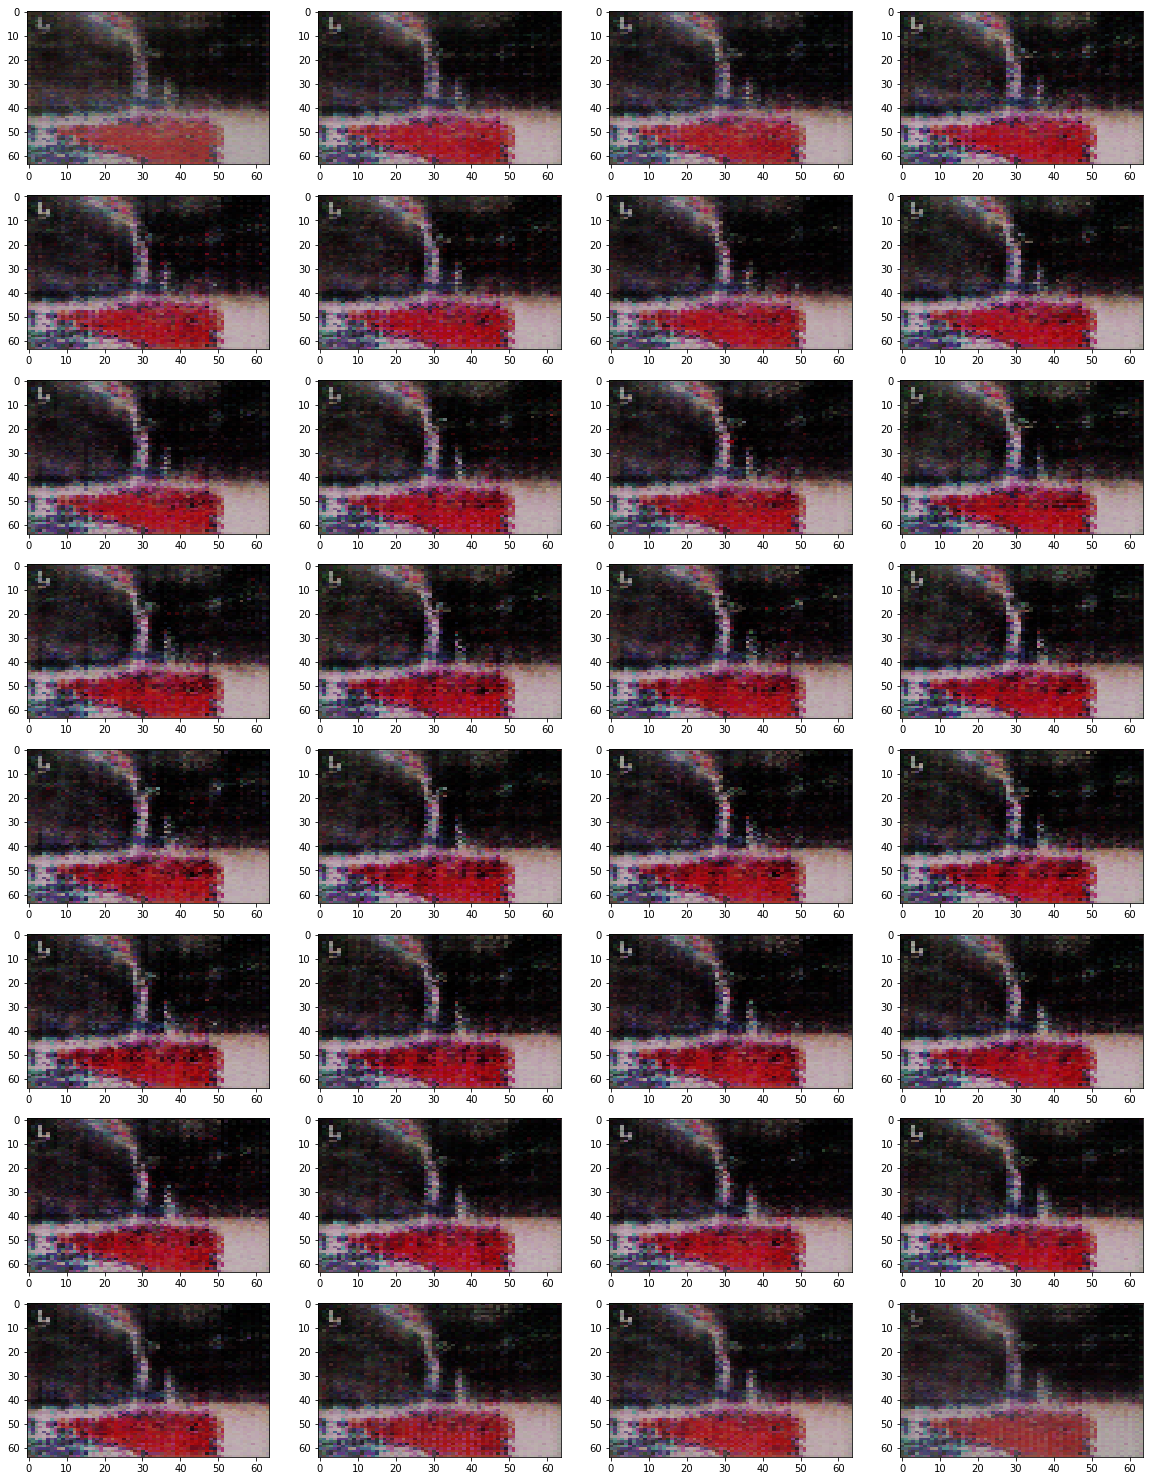

In [68]:
# split gifs into frames to display
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

%cd 
%cd /Users/jesusnavarro/Desktop/gan_video/

root = 'core/gen_videos/'

gifs = ['fake_gifs_sample_it21_epoch121.gif']
img = Image.open(root + gifs[0])
images = np.array([np.array(frame.copy().convert('RGB').getdata(),dtype=np.uint8).reshape(frame.size[1],frame.size[0],3)
                   for frame in ImageSequence.Iterator(img)])
columns=4
plt.figure(figsize=(20,30))

for i, image in enumerate(images):
    ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image, interpolation='nearest', aspect='auto')
plt.show()

(64, 64, 4)


# Challenges and Improvements

##### Training Challenges:

1. Training takes a very long time about 3-4 hours for this example. Scaling even larger will scale it by a factor of about 5-10. I am looking into implementing training on a GPU or finding ways to optimize training.

2. Generated images are very low resolution. This is a result of compressing images due to limited compute resources. If more compute power was available, the model would need to be changed to accomodate for the difference in image resolution. 

3. Performance stalls! This also impacts the resolution of the generated images due to the optimization stalling. 

4. Many generated videos are very static.

##### Data Challenges:

1. Filtering outliers. Since the highlight videos are from youtube, there were will be transitional static frames from one play to another that should not be included in the training process. Filtering such images can be challenging. Several things I tried to filter images:

    a. PCA : I reduced the dimensionality of each image using PCA and plotted on a 2D plot and attempted to cluster and find the outliers. However, since highlight videos often replay a scene from various angles, there were many clusters in the reduced space and sometimes very unstructured if too many points were plotted.
    
    b. Non-linear PCA: Issues similar to (a.) 
    
    c. K- nearest neighbors: I attempted to hand label (0 or 1) images and train a subset of k-nearest neighbors. However this also entailed reducing the dimension of the image and proved inefficient since hand labeling is time consuming.
    
    d. Computed mean values of each R,G, and B value for each image. I noticed many of the transitional frames were saturated with blue, and thus used a threshold value to clean the video and filter out non-desired data. This is a naive but effective method for this particular video.
    


##### Improvements/Changes to make:

1. Use a lower fps setting so that there are more dynamics for each training video.
2. Research different loss function or modifications to the model to increase performance
3. Apply a more sophisticated statistical analysis of the images to filter out non-related static frames. A way around this would be to actually train a neural network to detect if its a real-live basketball image, but that requires label